## Analyzing Webpage Conversions with Probability and A/B Testing


## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#data_wrangling)
    - [Gathering Data](#gathering_data)
    - [Assessing Data](#assessing_data)
    - [Cleaning Data](#cleaning_data)
- [Analysis](#analysis)
    - [Probabilistic Approach](#probabilistic_approach)
    - [A/B Testing](#ab_test)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

In this project, i will be analyzing an e-commerce company's website data. The analysis is done using **probabilistic** technique and **A/B test**, a technique commonly used by data analysts and data scientists. The company has developed a new webpage, and wants to know if it is better on attracting customers to buy its products. The goal is to help the company decide if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

The dataset has 294,478 rows and 5 columns. The columns are:
- `user_id` which is a unique identifier of each visitor, 
- `timestamp` show the data and time at which they visited the website,
- `group` denotes the experimental group to which visitors belong (_control_ or _treatment_),
- `landing_page` denotes the kind of webpage presented to visitors (_old page_ or _new page_),
- `converted` specifies if the customer has made a purchase using the presented webpage.


<a id='data_wrangling'></a>
### Data Wrangling

<a id='gathering_data'></a>
#### Gathering Data

`a.` Import libraries.

In [185]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`b.` Read in the dataset and take a look at the top few rows.

In [186]:
# Read the dataset
df = pd.read_csv('../data/ab_data.csv')

# Show the top 5 rows  
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`c.` Find the number of rows, unique users, and proportion of users who converted from the dataset.

In [187]:
# Get the number of rows and columns
rows, columns = enumerate(df.shape)
print('The dataset has {} rows and {} columns.'.format(rows[1], columns[1]))

# Get unique user ids
unique_users = df['user_id'].unique()
print('The dataset has {} unique users.'.format(unique_users.shape[0]))

# Get users who converted from those with unique id 
unique_converted_users = df.query('converted == 1 & user_id == {0}'.format(list(unique_users)))

# Calculate conversion rate 
unique_conversion_rate = (unique_converted_users.shape[0]/unique_users.shape[0]) * 100
print('{0:.0f}% of the unique users have converted.'.format(unique_conversion_rate))

The dataset has 294478 rows and 5 columns.
The dataset has 290584 unique users.
12% of the unique users have converted.


<a id='assessing_data'></a>
#### Assessing Data

##### Quality Issues


`a.` Mismatch between experimental _group_ and presented _webpage_. For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [188]:
# Get the data where treatment and new_page do not match
no_match_1 = df.query('group == "treatment" & landing_page != "new_page"')
no_match_2 = df.query('group != "treatment" & landing_page == "new_page"')

# Calculate the total miss match in the data
total_miss_match = (no_match_1.shape[0] + no_match_2.shape[0])
print('Experimental group and presented page do not match {} times.'.format(total_miss_match))

Experimental group and presented page do not match 3893 times.


`b`. Data type of `timestamp` is _string_ but should be _datetime_ type.

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`c`. 3894 duplicate `user_id`s.

In [190]:
# Get the user with duplicate entry 
duplicated_user = df[df['user_id'].duplicated()]
print('There are {} duplicated user ids.'.format(duplicated_user.shape[0]))

There are 3894 duplicated user ids.


<a id='cleaning_data'></a>
#### Cleaning Data

##### Define

`a.` _Drop_ rows where experimental _group_ and presented _webpage_ don't line up.

##### Code

In [191]:
# Get the indexes where there is no match
index_list = no_match_1.index.append(no_match_2.index)

# Drop rows where there is no match
df2 = df.drop(index=index_list)

##### Test


In [192]:
# Double Check all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') & (df2['landing_page'] == 'old_page')) | 
    ((df2['group'] != 'treatment') & (df2['landing_page'] == 'new_page'))].shape[0]

0

##### Define

`b.` Convert `timestamp` to _datetime_ type using `pd.to_datetime()`.

##### Code

In [193]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

##### Test


In [194]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null datetime64[ns]
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.3+ MB


##### Define

`c.` Get indices of the duplicated user records, then drop them.

##### Code

In [195]:
# Get indeces of the duplicated user records again
duplicated_user = df2.user_id[df2.user_id.duplicated()]

# Drop the duplicate user records
df2.drop(index=duplicated_user.index, inplace=True)

##### Test


In [196]:
# Check if there are any duplicate user records
df2[df2['user_id'].duplicated()].shape[0]

0

<a id='analysis'></a>
### Analysis

<a id='probabilistic_approach'></a>
#### Probabilistic Approach


`a.` What is the probability of conversion regardless of the landing page?

In [197]:
# Calculate probability of conversion
p_conversion = (df2['converted'] == 1).mean()
print('The probability of conversion, regardless of landing page, is {0:.4f}.'.format(p_conversion))

The probability of conversion, regardless of landing page, is 0.1196.


`b.` Given that an individual was in the _control_ group, what is the probability of conversion?

In [198]:
# Count number of customers in the control group, and 
# Count number of customers who converted from the control group
control = df2.query('group == "control"').shape[0]
converted_and_control = df2.query('converted == 1 & group == "control"').shape[0]

# Calculate probability of conversion for an individual in the control group
p_converted_and_control = converted_and_control/control
print('The probability of conversion, for an individual in the control group, is {0:.4f}.'.format(p_converted_and_control))

The probability of conversion, for an individual in the control group, is 0.1204.


`c.` Given that an individual was in the _treatment_ group, what is the probability of conversion?

In [199]:
# Count number of customers in the treatment group, and 
# Count number of customers who converted from the treatment group
treatment = df2.query('group == "treatment"').shape[0]
converted_and_treatment = df2.query('converted == 1 & group == "treatment"').shape[0]

# Calculate probability of conversion for an individual in the treatment group
p_converted_and_treatment = converted_and_treatment/treatment
print('The probability of conversion, for an individual in the treatment group, is {0:.4f}.'.format(p_converted_and_treatment))

The probability of conversion, for an individual in the treatment group, is 0.1188.


`d.` What is the probability that an individual received the _new page_?

In [200]:
# Calculate proportion of individuals who received the new page
new_page = df2.query('landing_page == "new_page"')
p_new_page = new_page.shape[0]/df2.shape[0]
print('The probability of receiving the new page is {0:.4f}.'.format(p_new_page))

The probability of receiving the new page is 0.5001.


**Conclusion**    
Is there any sufficient evidence to say that the new webpage leads to more conversions?

**Answer**    
From the total observations, **each group has equal proportion**. The probability of conversion after seeing the old or new page is $\approx 12 \text{%}$. Hence; individuals who were presented with the old page are, **equally likely** to convert when compared with those with the new page.    
Therefore; there is **no enough evidence** to say "the new page leads to more conversions".

<a id='ab_test'></a>
### A/B Testing


Lets assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.    

`a.` The null and alternative hypotheses become:

$$ H_0: p_{old} \geq p_{new} $$ 
$$ H_1: p_{old} < p_{new} $$
Equivalently:    
$$ H_0: p_{new} - p_{old} \leq 0 $$ 
$$ H_1: p_{new} - p_{old} > 0 $$

Where **$p_{old}$** and **$p_{new}$** are conversion rates of the old and new page respectively.

`b.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

`b.` What is the difference in the **convert rate** ($p_{new} - p_{old}$) between $p_{new}$ and $p_{old}$? 

In [201]:
# Calculate conversion rate for the new page
p_new = p_converted_and_treatment#  ((df2['landing_page'] == "new_page") & (df2['converted'] == 1) == True).mean()
print('Conversion rate of the new page is {0:.4f}.'.format(p_new))

# Calculate conversion rate for the old page
p_old = p_converted_and_control#  ((df2['landing_page'] == "old_page") & (df2['converted'] == 1) == True).mean()
print('Conversion rate of the old page is {0:.4f}.'.format(p_old))

# Calculate the difference in conversion rate 
print('Difference in conversion rate is {0:.4f}.'.format(p_new - p_old))

Conversion rate of the new page is 0.1188.
Conversion rate of the old page is 0.1204.
Difference in conversion rate is -0.0016.


`c.` What are $n_{new}$, $n_{old}$, and $n_{sample}$?

In [202]:
n_new = len(new_page)
print('Size of samples from new page are {}.'.format(n_new))

# Get how may individuals received the old page
old_page = df2.query('landing_page == "old_page"')
n_old = len(old_page)
print('Size of samples from old page are {}.'.format(n_old))

# Get the sample size
n_sample = len(df2)
print('Size of the sample is {}.'.format(n_sample))

Size of samples from new page are 145310.
Size of samples from old page are 145274.
Size of the sample is 290584.


`d.` Simulate 10,000 draws of $p_{new}$ - $p_{old}$ values, which help us to be more representative of the population.

In [203]:
p_diffs = np.array([])

# Compute the sampling distribution
for _ in range(10000):
    # Generate elements from the new/old page groups using their probability
    new_page_converted = np.random.choice([0, 1], size = n_new, replace = True, p = [1-p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, replace = True, p = [1-p_old, p_old])
    
    # Calculate the difference in conversion rates
    p_diffs = np.append(p_diffs, new_page_converted.mean() - old_page_converted.mean())

`e.` Simulate $n_{sample}$ draws that imitate the closest value to the parameter under null hypothesis, and plot this distribution.

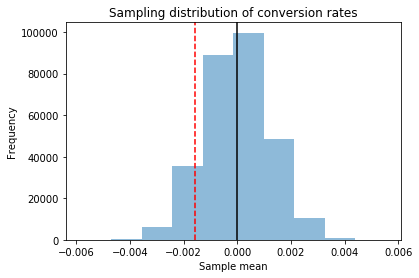

In [204]:
# Generate elements equal to the size of our sample size 
# that imitate the null hypothesis
p_diffs_null = np.random.normal(0, p_diffs.std(), size = n_sample)

# Plot the distribution under the null along with the location of the sample mean
plt.hist(p_diffs_null, alpha=0.5)
plt.axvline(x = p_diffs.mean(), color = 'r', linestyle = '--')
plt.axvline(x = p_diffs_null.mean(), color = 'k', linestyle = '-')
plt.title('Sampling distribution of conversion rates')
plt.ylabel('Frequency')
plt.xlabel('Sample mean')
plt.show();

`f.` What proportion of the **p_diffs_null** are greater than the actual difference observed in the dataset?

In [205]:
observed_diff = p_new - p_old

# Calculate p-value
p_value = (p_diffs_null > observed_diff).mean()
print('The probability of obseving the difference in conversion rate or higher values, \n' + 
      'given that the null hypothesis is true, = {0:.2f}.'.format(p_value))

The probability of obseving the difference in conversion rate or higher values, 
given that the null hypothesis is true, = 0.90.


`g.` What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**    
The value computed above is, the _probability of seeing the sample statistic_ if the null hypothesis is true. In scientific studies this value is called **p-value**. In our case; it means that the probability of getting the `observed_diff` is high if the null hypothesis is true. Hence; if the null hypothesis is true, conversions through the old page are equal or higher when compared with the new page. As a result; we can conclude that **the old page is performing the same as the new webpage**.

`h.` We could also use a built-in function to achieve a similar result. Using _statsmodels_' `stats.proportions_ztest` function we can compute the test statistic and p-value.

In [206]:
# Import library
import statsmodels.api as sm

# Get the number of conversions from each group
old_page_converted = len(old_page.query('converted == 1'))
new_page_converted = len(new_page.query('converted == 1'))

# Get z_score and p_values
z_score, p_value = sm.stats.proportions_ztest([new_page_converted, old_page_converted], [n_new, n_old], alternative='larger')
print('Z-score is {0:.2f} and p-value is {1:.2f}.'.format(z_score, p_value))

Z-score is -1.31 and p-value is 0.91.


`i.` What do the z-score and p-value you mean for the conversion rates of the old and new pages? 

**Answer**    
With 0.05 type 1 error rate (0.95 confidence level), the null hypothesis gets rejected if Z-score of the sample statistic is less than -1.96 or greater than +1.96. However; Z-score is -1.31, which is out of the rejection region. Furthermore; the p-value is close to 1, which signifies we have to stay with the null hypothesis (**the old page is performing in the same way as the new page**). So, there is no statistically significant evidence to reject the null hypothesis, and this conclusion matches with the findings in question **f.** and **g.**

<a id='conclusion'></a>
### Conclusion
  
* Using both techiques (i.e. probabilistic and A/B testing) we were able to see if the newly developed webpage is better on attracting customers to buy products. Remember that the goal was to help the company decide if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. Results show that the newly developed page does not proves to be better. Hence; we can recommend the company to **keep the older webpage**.  